<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/Improved_MLP(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ================================================================
# STEP 1: Import Required Libraries
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:

# ================================================================
# STEP 2: Load and Prepare Data
# ================================================================
def create_production_labels(production_values, quantiles):
    """Create quantile-based production labels"""
    labels = []
    for val in production_values:
        if val <= quantiles[0]:
            labels.append('very low')
        elif val <= quantiles[1]:
            labels.append('low')
        elif val <= quantiles[2]:
            labels.append('medium')
        elif val <= quantiles[3]:
            labels.append('high')
        else:
            labels.append('very high')
    return labels

# Load datasets
try:
    train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
    val_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')
    print(f"Data loaded successfully!")
    print(f"Train shape: {train_df.shape}")
    print(f"Validation shape: {val_df.shape}")
    print(f"Test shape: {test_df.shape}")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")


Data loaded successfully!
Train shape: (3942, 84)
Validation shape: (845, 84)
Test shape: (845, 84)


In [3]:

# ================================================================
# STEP 3: Create Production Labels
# ================================================================
# Combine all data to calculate quantiles consistently
all_data = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Create quantile-based labels for production
production_col = 'Production (M.Ton)'
quantiles = all_data[production_col].quantile([0.2, 0.4, 0.6, 0.8]).values

# Apply labels to each dataset
train_df['production_label'] = create_production_labels(train_df[production_col], quantiles)
val_df['production_label'] = create_production_labels(val_df[production_col], quantiles)
test_df['production_label'] = create_production_labels(test_df[production_col], quantiles)

print("\nProduction label distribution:")
print("Training:", train_df['production_label'].value_counts().sort_index())
print("Validation:", val_df['production_label'].value_counts().sort_index())
print("Testing:", test_df['production_label'].value_counts().sort_index())



Production label distribution:
Training: production_label
high         790
low          817
medium       774
very high    786
very low     775
Name: count, dtype: int64
Validation: production_label
high         160
low          142
medium       190
very high    169
very low     184
Name: count, dtype: int64
Testing: production_label
high         176
low          167
medium       162
very high    172
very low     168
Name: count, dtype: int64


In [4]:

# ================================================================
# STEP 4: Prepare Features and Labels
# ================================================================
# Separate features and labels
feature_cols = [col for col in train_df.columns if col not in [production_col, 'production_label']]

X_train = train_df[feature_cols].values
X_val = val_df[feature_cols].values
X_test = test_df[feature_cols].values

# Encode labels
label_encoder = LabelEncoder()
all_labels = np.concatenate([train_df['production_label'], val_df['production_label'], test_df['production_label']])
label_encoder.fit(all_labels)

y_train = label_encoder.transform(train_df['production_label'])
y_val = label_encoder.transform(val_df['production_label'])
y_test = label_encoder.transform(test_df['production_label'])

# Convert to categorical for neural network
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"\nFeature shape: {X_train.shape[1]}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")


Feature shape: 83
Number of classes: 5
Classes: ['high' 'low' 'medium' 'very high' 'very low']


In [5]:


# ================================================================
# STEP 5: Preprocess Data (Standardization)
# ================================================================
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed!")
print(f"Training features scaled shape: {X_train_scaled.shape}")
print(f"Validation features scaled shape: {X_val_scaled.shape}")
print(f"Test features scaled shape: {X_test_scaled.shape}")


Data preprocessing completed!
Training features scaled shape: (3942, 83)
Validation features scaled shape: (845, 83)
Test features scaled shape: (845, 83)


In [6]:

# ================================================================
# STEP 6: Build Improved MLP Model
# ================================================================
def build_improved_mlp(input_shape, num_classes, dropout_rate=0.4):
    """Build improved MLP with BatchNorm, Dropout, and multiple hidden layers"""

    model = Sequential([
        # Input layer
        Dense(512, input_shape=(input_shape,)),
        BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.01),
        Dropout(dropout_rate),

        # Hidden layer 1
        Dense(256),
        BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.01),
        Dropout(dropout_rate),

        # Hidden layer 2
        Dense(128),
        BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.01),
        Dropout(dropout_rate),

        # Hidden layer 3
        Dense(64),
        BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.01),
        Dropout(dropout_rate),

        # Hidden layer 4
        Dense(32),
        BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=0.01),
        Dropout(dropout_rate * 0.5),  # Reduced dropout for deeper layers

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build the model
model = build_improved_mlp(X_train_scaled.shape[1], num_classes)

print("Model architecture:")
model.summary()


Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        43,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,701 (866.02 KB)

 Trainable params: 219,717 (858.27 KB)

 Non-trainable params: 1,984 (7.75 KB)

In [7]:

# ================================================================
# STEP 7: Define Training Callbacks
# ================================================================
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-7,
    verbose=1
)

print("Training callbacks defined successfully!")


Training callbacks defined successfully!


In [8]:

# ================================================================
# STEP 8: Train the Model
# ================================================================
# Train model
epochs = 100
print(f"\nStarting training for {epochs} epochs...")

history = model.fit(
    X_train_scaled, y_train_cat,
    epochs=epochs,
    batch_size=64,
    validation_data=(X_val_scaled, y_val_cat),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Training completed!")



Starting training for 100 epochs...
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.2264 - loss: 1.7957 - val_accuracy: 0.4047 - val_loss: 1.4993 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.2790 - loss: 1.6051 - val_accuracy: 0.4710 - val_loss: 1.3081 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3960 - loss: 1.4026 - val_accuracy: 0.5077 - val_loss: 1.1533 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4628 - loss: 1.2746 - val_accuracy: 0.5408 - val_loss: 1.0758 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4854 - loss: 1.1843 - val_accuracy: 0.5704 - val_loss: 0.9867 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5504 - loss: 1.0885 - val_accuracy: 0.6166 - val_loss: 0.9150 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

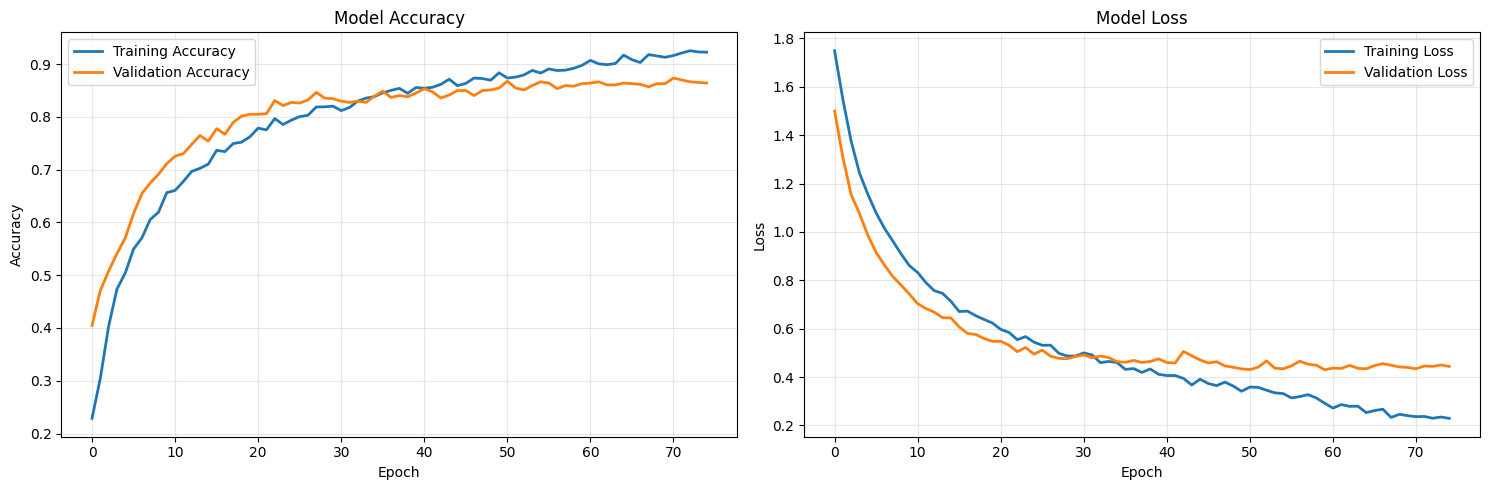

In [9]:

# ================================================================
# STEP 9: Plot Training History
# ================================================================
def plot_training_history(history):
    """Plot training and validation accuracy/loss"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)


In [10]:

# ================================================================
# STEP 10: Make Predictions
# ================================================================
print("\nMaking predictions...")

# Validation predictions
y_val_pred_probs = model.predict(X_val_scaled)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Test predictions
y_test_pred_probs = model.predict(X_test_scaled)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

print("Predictions completed!")
print(f"Validation predictions shape: {y_val_pred.shape}")
print(f"Test predictions shape: {y_test_pred.shape}")



Making predictions...
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predictions completed!
Validation predictions shape: (845,)
Test predictions shape: (845,)


In [11]:

# ================================================================
# STEP 11: Define Evaluation Functions
# ================================================================
def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive metrics"""

    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    metrics = {
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Weighted)': precision_weighted,
        'Recall (Macro)': recall_macro,
        'Recall (Weighted)': recall_weighted,
        'F1 Score (Macro)': f1_macro,
        'F1 Score (Weighted)': f1_weighted
    }

    return metrics

def plot_confusion_matrix(y_true, y_pred, label_encoder, title, dataset_name):
    """Plot confusion matrix"""

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'{title} - {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [12]:

# ================================================================
# STEP 12: Calculate Validation Set Metrics
# ================================================================
print("\n" + "="*50)
print("VALIDATION SET RESULTS")
print("="*50)

val_metrics = calculate_metrics(y_val, y_val_pred)
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")



VALIDATION SET RESULTS
Accuracy: 0.8627
Precision (Macro): 0.8598
Precision (Weighted): 0.8636
Recall (Macro): 0.8623
Recall (Weighted): 0.8627
F1 Score (Macro): 0.8602
F1 Score (Weighted): 0.8623


In [13]:

# ================================================================
# STEP 13: Calculate Test Set Metrics
# ================================================================
print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)

test_metrics = calculate_metrics(y_test, y_test_pred)
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")



TEST SET RESULTS
Accuracy: 0.8627
Precision (Macro): 0.8629
Precision (Weighted): 0.8630
Recall (Macro): 0.8618
Recall (Weighted): 0.8627
F1 Score (Macro): 0.8619
F1 Score (Weighted): 0.8624



Generating confusion matrices...


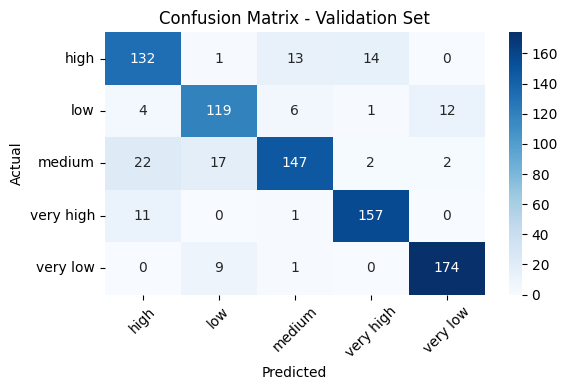

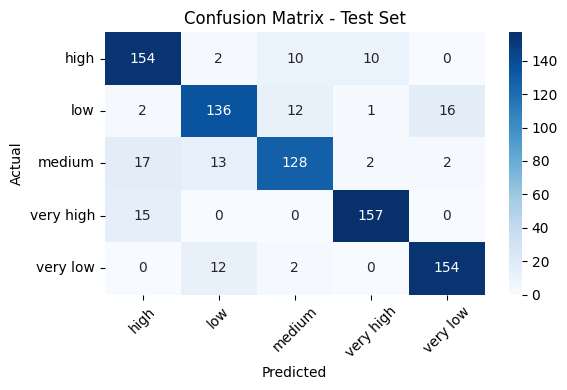

In [14]:

# ================================================================
# STEP 14: Plot Confusion Matrices
# ================================================================
print("\nGenerating confusion matrices...")

# Validation confusion matrix
plot_confusion_matrix(y_val, y_val_pred, label_encoder,
                     "Confusion Matrix", "Validation Set")

# Test confusion matrix
plot_confusion_matrix(y_test, y_test_pred, label_encoder,
                     "Confusion Matrix", "Test Set")


In [15]:

# ================================================================
# STEP 15: Generate Classification Reports
# ================================================================
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT - VALIDATION SET")
print("="*50)
print(classification_report(y_val, y_val_pred,
                          target_names=label_encoder.classes_))

print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT - TEST SET")
print("="*50)
print(classification_report(y_test, y_test_pred,
                          target_names=label_encoder.classes_))



DETAILED CLASSIFICATION REPORT - VALIDATION SET
              precision    recall  f1-score   support

        high       0.78      0.82      0.80       160
         low       0.82      0.84      0.83       142
      medium       0.88      0.77      0.82       190
   very high       0.90      0.93      0.92       169
    very low       0.93      0.95      0.94       184

    accuracy                           0.86       845
   macro avg       0.86      0.86      0.86       845
weighted avg       0.86      0.86      0.86       845


DETAILED CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

        high       0.82      0.88      0.85       176
         low       0.83      0.81      0.82       167
      medium       0.84      0.79      0.82       162
   very high       0.92      0.91      0.92       172
    very low       0.90      0.92      0.91       168

    accuracy                           0.86       845
   macro avg       0.86      0.86      

In [16]:

# ================================================================
# STEP 16: Summary Comparison
# ================================================================
print("\n" + "="*50)
print("SUMMARY COMPARISON")
print("="*50)
print(f"{'Metric':<20} {'Validation':<12} {'Test':<12}")
print("-" * 50)

comparison_metrics = ['Accuracy', 'F1 Score (Macro)', 'F1 Score (Weighted)']
for metric in comparison_metrics:
    print(f"{metric:<20} {val_metrics[metric]:<12.4f} {test_metrics[metric]:<12.4f}")

print("\n" + "="*50)
print("PIPELINE EXECUTION COMPLETED SUCCESSFULLY!")
print("="*50)


SUMMARY COMPARISON
Metric               Validation   Test        
--------------------------------------------------
Accuracy             0.8627       0.8627      
F1 Score (Macro)     0.8602       0.8619      
F1 Score (Weighted)  0.8623       0.8624      

PIPELINE EXECUTION COMPLETED SUCCESSFULLY!
